In [8]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [23]:

class LinearHT:

    def __init__(self, ip, aSteps, rSteps):
        self.ip = ip # reference to original image
        self.xCtr = len(ip[0]) // 2 # x-coordinate of image center
        self.yCtr = len(ip) // 2 # y-coordinate of image center
        self.nAng = aSteps # number of steps for angle
        self.dAng = math.pi / self.nAng # stepsize of angle
        self.nRad = rSteps # number of steps for radius
        self.rMax = math.sqrt(self.xCtr ** 2 + self.yCtr ** 2)
        self.dRad = (2*self.rMax) / self.nRad # stepsize of radius
        self.houghArray = np.zeros((self.nAng, self.nRad), dtype=np.float32)
        self.fillHoughAccumulator()
    
    def fillHoughAccumulator(self):
        for v in range(len(self.ip)):
            for u in range(len(self.ip[0])):
                if self.ip[v][u] > 0:
                    self.doPixel(u, v)
    
    def doPixel(self, u, v):
        x = u - self.xCtr
        y = v - self.yCtr
        for a in range(self.nAng):
            theta = self.dAng * a
            r = int(round((x * math.cos(theta) + y * math.sin(theta)) / self.dRad) + self.nRad // 2)
            if r >= 0 and r < self.nRad:
                self.houghArray[r][a] += 1

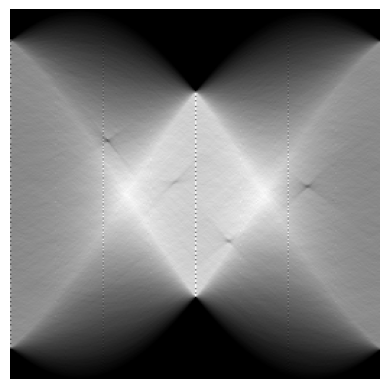

In [24]:
img = cv2.imread("noisy-lines.tif", cv2.IMREAD_GRAYSCALE)

test = LinearHT(img, 256, 256)
show = np.array(255 * test.houghArray / np.max(test.houghArray), dtype=np.uint8)

invert = np.vectorize(lambda x: 255 - x)

#show = invert(show)

plt.imshow(show, cmap='gray')
plt.axis('off')
plt.show()